In [1]:
# init pyimage to get access to jar files
import imagej
ij = imagej.init('C:/programs/fiji-win64/Fiji.app/')

# load some image data
from skimage import io
sk_img = io.imread('https://samples.fiji.sc/blobs.png')

# init clijpy to get access to the GPU
from jnius import autoclass
CLIJx = autoclass('net.haesleinhuepf.clijx.CLIJx')
clijx = CLIJx.getInstance();

Added 426 JARs to the Java classpath.


In [2]:
def showImages(img1, img2):
    vals = np.linspace(0,1,256)
    np.random.shuffle(vals)
    
    # show the input and the result image
    from matplotlib import pyplot as plt
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    plt.subplot(121)
    plt.imshow(img1)
    plt.subplot(122)
    plt.imshow(img2, cmap=cmap, vmin=0, vmax=65)
    plt.show()

In [3]:
# convert an array to an ImageJ2 img:
import numpy as np
np_arr = np.array(sk_img)
ij_img = ij.py.to_java(np_arr)

# push the image to the GPU
input8 = clijx.push(ij_img)

# convert it to Float
input = clijx.create(input8.getDimensions()) # generates a Float image
# actual conversion
clijx.copy(input8, input)

True

In [4]:
# reserve memory for output, same size and type as input
blurred = clijx.create(input);
thresholded = clijx.create(input);
labelled = clijx.create(input);
labelled_without_edges = clijx.create(input);

In [5]:
# blur, threshold and label the image
clijx.blur(input, blurred, 5, 5, 0);
clijx.automaticThreshold(blurred, thresholded, "Otsu");
clijx.connectedComponentsLabeling(thresholded, labelled);
clijx.excludeLabelsOnEdges(labelled, labelled_without_edges);

Way 1: 1.67 +- 0.4910193478876367
Way 2: 7.61 +- 0.9369631796394136
Way 3: 3.51 +- 0.8306021911842033


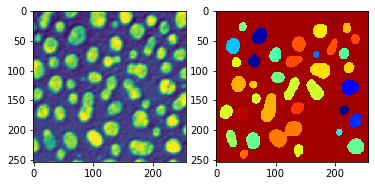

In [17]:
# pull image back from GPU
RandomAccessibleInterval = autoclass('net.imglib2.RandomAccessibleInterval');
ij_img_result = clijx.convert(labelled_without_edges, RandomAccessibleInterval);
imageplus_result = clijx.pull(labelled_without_edges);
# 
# convert to numpy/python
import time
def getTime():
    return int(round(time.time() * 1000))

def clijx_pull(buffer):
    import numpy
    numpy_image = numpy.zeros([buffer.getWidth(), buffer.getHeight(), buffer.getDepth()])
    wrapped = ij.py.to_java(numpy_image);
    clijx.pullToRAI(buffer, wrapped); # see https://github.com/clij/clij-advanced-filters/blob/master/src/main/java/net/haesleinhuepf/clijx/CLIJx.java#L87 
    return numpy_image

def my_rai_to_numpy(rai):
    result = ij.py.new_numpy_image(rai)
    CopyRAI = autoclass('net.imagej.ops.copy.CopyRAI');
    ij.py._ij.op().run(CopyRAI, ij.py.to_java(result), rai)
    return result

num_iterations = 100;

way1timings = np.zeros(num_iterations);
way2timings = np.zeros(num_iterations);
way3timings = np.zeros(num_iterations);

for it in range(0, num_iterations):
    #########################################################
    # Way 1
    millis = getTime();
    np_arr_result = clijx_pull(labelled_without_edges);
    way1timings[it] = (getTime() - millis)

    #########################################################
    # Way 2
    ij_img_result = clijx.convert(labelled_without_edges, RandomAccessibleInterval); # we exclude clij routines for benchmarking conversion if possible
    millis = getTime();
    np_arr_result = ij.py.rai_to_numpy(ij_img_result);
    way2timings[it] = (getTime() - millis)

    #########################################################
    # Way 3
    ij_img_result = clijx.convert(labelled_without_edges, RandomAccessibleInterval); # we exclude clij routines for benchmarking conversion if possible
    millis = getTime();
    np_arr_result = my_rai_to_numpy(ij_img_result);
    way3timings[it] = (getTime() - millis)
    
    #########################################################
print("Way 1: " + str(np.mean(way1timings)) + " +- " + str(np.std(way1timings)));
print("Way 2: " + str(np.mean(way2timings)) + " +- " + str(np.std(way2timings)));
print("Way 3: " + str(np.mean(way3timings)) + " +- " + str(np.std(way3timings)));


# show the input and the result image
showImages(np_arr, np_arr_result);

In [7]:
# clean up
input.close();
blurred.close();
thresholded.close();
labelled.close();
labelled_without_edges.close();